# Preparing Dataset
### Load from csv

In [1]:
# !pip3 install tensorflow
# !pip3 install numpy
# !pip3 install tensorflow
# !pip3 install tf_keras
# Clean existing installations

# Clear existing packages
%pip uninstall -y tensorflow tensorflow-hub tensorflow-text tensorflow-metal tensorflow-macos tensorflow-text

# Install TensorFlow and Metal plugin
%pip install tensorflow

# Install dependencies
%pip install tensorflow-hub
%pip install tensorflow-text

%pip install pydot
%pip install graphviz


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
Found existing installation: tensorflow-text 2.18.1
Uninstalling tensorflow-text-2.18.1:
  Successfully uninstalled tensorflow-text-2.18.1
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp39-cp39-macosx_12_0_arm64.whl (239.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.18.0 requires tensorflow-hub>=0.6.0, which is not installed.
tf-models-official 2.18.0 requires tensorflow-text~=2.18.0, which is not installed.
You should consider upgrading via the '/

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['TF_USE_LEGACY_KERAS']='1'


import pandas as pd






### Import fr this time

In [3]:
all_notes = pd.read_csv("/Users/amanagrawal/Desktop/Mass General Data/all_notes.csv")

pt_labels = pd.read_csv("/Users/amanagrawal/Desktop/Mass General Data/PT_Labels.csv")

#create new dataframe where all notes with same patient ID and note number are combined
# It eliminates the notes split into multiple parts
all_notes = all_notes.groupby(['PATIENTID_MODIFIED', 'PATIENTENCOUNTERID_MODIFIED', 'NOTEID_MODIFIED', 'AUTHORSERVICEDSC'])['NOTETXT'].apply(
    ' '.join).reset_index()  #['NOTETXT'].apply(' '.join).reset_index()

# Merge based on Note ID, called NOTEID_MODIFIED in all_notes and NOTE ID in pt_labels
all_notes = all_notes.rename(columns={'NOTEID_MODIFIED': 'NOTE ID'})

#remove all non pt notes
pt_notes = all_notes[all_notes['AUTHORSERVICEDSC'] == "Physical Therapy"]


merged = pd.merge(pt_notes, pt_labels, on='NOTE ID')


merged = merged[['NOTETXT', 'Rolling', 'Supine-sit', 'Transfers', 'Ambulation', 'Stairs']]

# remove everything except whats in parentheses for the columns rolling, supine-sit, transfers, ambulation, stairs
merged['Rolling'] = merged['Rolling'].str.extract(r"\((.*?)\)", expand=False)
merged['Supine-sit'] = merged['Supine-sit'].str.extract(r"\((.*?)\)", expand=False)
merged['Transfers'] = merged['Transfers'].str.extract(r"\((.*?)\)", expand=False)
merged['Ambulation'] = merged['Ambulation'].str.extract(r"\((.*?)\)", expand=False)
merged['Stairs'] = merged['Stairs'].str.extract(r"\((.*?)\)", expand=False)

#remove all rows with NaN values
merged = merged.dropna()

#drop everything unnecessary
merged = merged[['NOTETXT', 'Rolling', 'Supine-sit', 'Transfers', 'Ambulation', 'Stairs']]

# make a tensorflow dataset from merged
#df = tf.data.Dataset.from_tensor_slices((merged['NOTETXT'], merged[['Rolling', 'Supine-sit', 'Transfers', 'Ambulation', 'Stairs']]))

#ensure that the columns are integers
merged['Rolling'] = merged['Rolling'].astype(int)
merged['Supine-sit'] = merged['Supine-sit'].astype(int)
merged['Transfers'] = merged['Transfers'].astype(int)
merged['Ambulation'] = merged['Ambulation'].astype(int)
merged['Stairs'] = merged['Stairs'].astype(int)

merged.to_csv("/Users/amanagrawal/Desktop/Mass General Data/merged_pt.csv")

# USING THE CHATGPT NOTES:
merged = pd.read_csv("/Users/amanagrawal/Downloads/research_chatgpt_notes.csv")

# Create the model



### BERT Layer

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import tensorflow_text
from sklearn.preprocessing import LabelEncoder


#Ensure there are no duplicates in merged
merged = merged.drop_duplicates(subset=['NOTETXT'])

# Encode target labels (1 to 4)
label_encoder = LabelEncoder()
merged['Rolling'] = label_encoder.fit_transform(merged['Rolling'])
merged['Supine-sit'] = label_encoder.fit_transform(merged['Supine-sit'])
merged['Transfers'] = label_encoder.fit_transform(merged['Transfers'])
merged['Ambulation'] = label_encoder.fit_transform(merged['Ambulation'])
merged['Stairs'] = label_encoder.fit_transform(merged['Stairs'])


# BERT model name
bert_model_name = "small_bert/bert_en_uncased_L-4_H-512_A-8"

# TODO: Switch to MedBERT
tfhub_handle_preprocess = f"https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = f"https://tfhub.dev/tensorflow/{bert_model_name}/1"

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, name='bert_preprocess')
bert_encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_encoder')




/Users/amanagrawal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### The rest of the model

In [6]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = bert_preprocess_model(text_input)
    encoder_outputs = bert_encoder(preprocessing_layer)
    net = encoder_outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)



In [7]:
classifier_model = build_classifier_model()

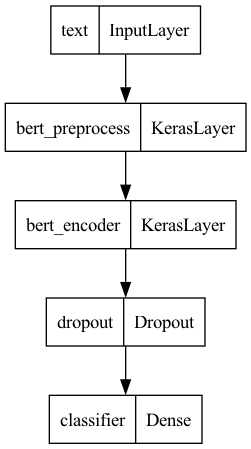

In [8]:
tf.keras.utils.plot_model(classifier_model)

# Train the Model

In [12]:
classifier_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

max_epochs = 99
val_split = 0.4
early_stopping_patience = 5

rolling_history = classifier_model.fit(
    x=merged["NOTETXT"],
    y=merged["Rolling"],
    validation_split=val_split,
    epochs=max_epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=early_stopping_patience, verbose=1, restore_best_weights=True)]
    
)
supine_history = classifier_model.fit(
    x=merged["NOTETXT"],
    y=merged["Supine-sit"],
    validation_split=val_split,
    epochs=max_epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=early_stopping_patience, verbose=1, restore_best_weights=True)]
)
transfer_history = classifier_model.fit(
    x=merged["NOTETXT"],
    y=merged["Transfers"],
    validation_split=val_split,
    epochs=max_epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=early_stopping_patience, verbose=1, restore_best_weights=True)]
)
ambulation_history = classifier_model.fit(
    x=merged["NOTETXT"],
    y=merged["Ambulation"],
    validation_split=val_split,
    epochs=max_epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=early_stopping_patience, verbose=1, restore_best_weights=True)]
)
stairs_history = classifier_model.fit(
    x=merged["NOTETXT"],
    y=merged["Stairs"],
    validation_split=val_split,
    epochs=max_epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=early_stopping_patience, verbose=1, restore_best_weights=True)]
)



Epoch 1/99
2/2 [==============================] - 2s 644ms/step - loss: 0.2532 - accuracy: 0.9167 - val_loss: 0.3655 - val_accuracy: 0.8333
Epoch 2/99
2/2 [==============================] - 1s 389ms/step - loss: 0.2333 - accuracy: 0.9167 - val_loss: 0.3932 - val_accuracy: 0.8333
Epoch 3/99
2/2 [==============================] - 1s 363ms/step - loss: 0.2267 - accuracy: 0.9167 - val_loss: 0.4989 - val_accuracy: 0.8333
Epoch 4/99
2/2 [==============================] - 1s 377ms/step - loss: 0.2231 - accuracy: 0.9167 - val_loss: 0.5289 - val_accuracy: 0.8333
Epoch 5/99
2/2 [==============================] - 1s 395ms/step - loss: 0.2151 - accuracy: 0.9167 - val_loss: 0.5210 - val_accuracy: 0.8333
Epoch 6/99
2/2 [==============================] - 1s 388ms/step - loss: 0.1424 - accuracy: 0.9722 - val_loss: 0.4835 - val_accuracy: 0.8333
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 1/99
2/2 [==============================] - 1s 424ms/step - loss: 0.240

# Generate Charts

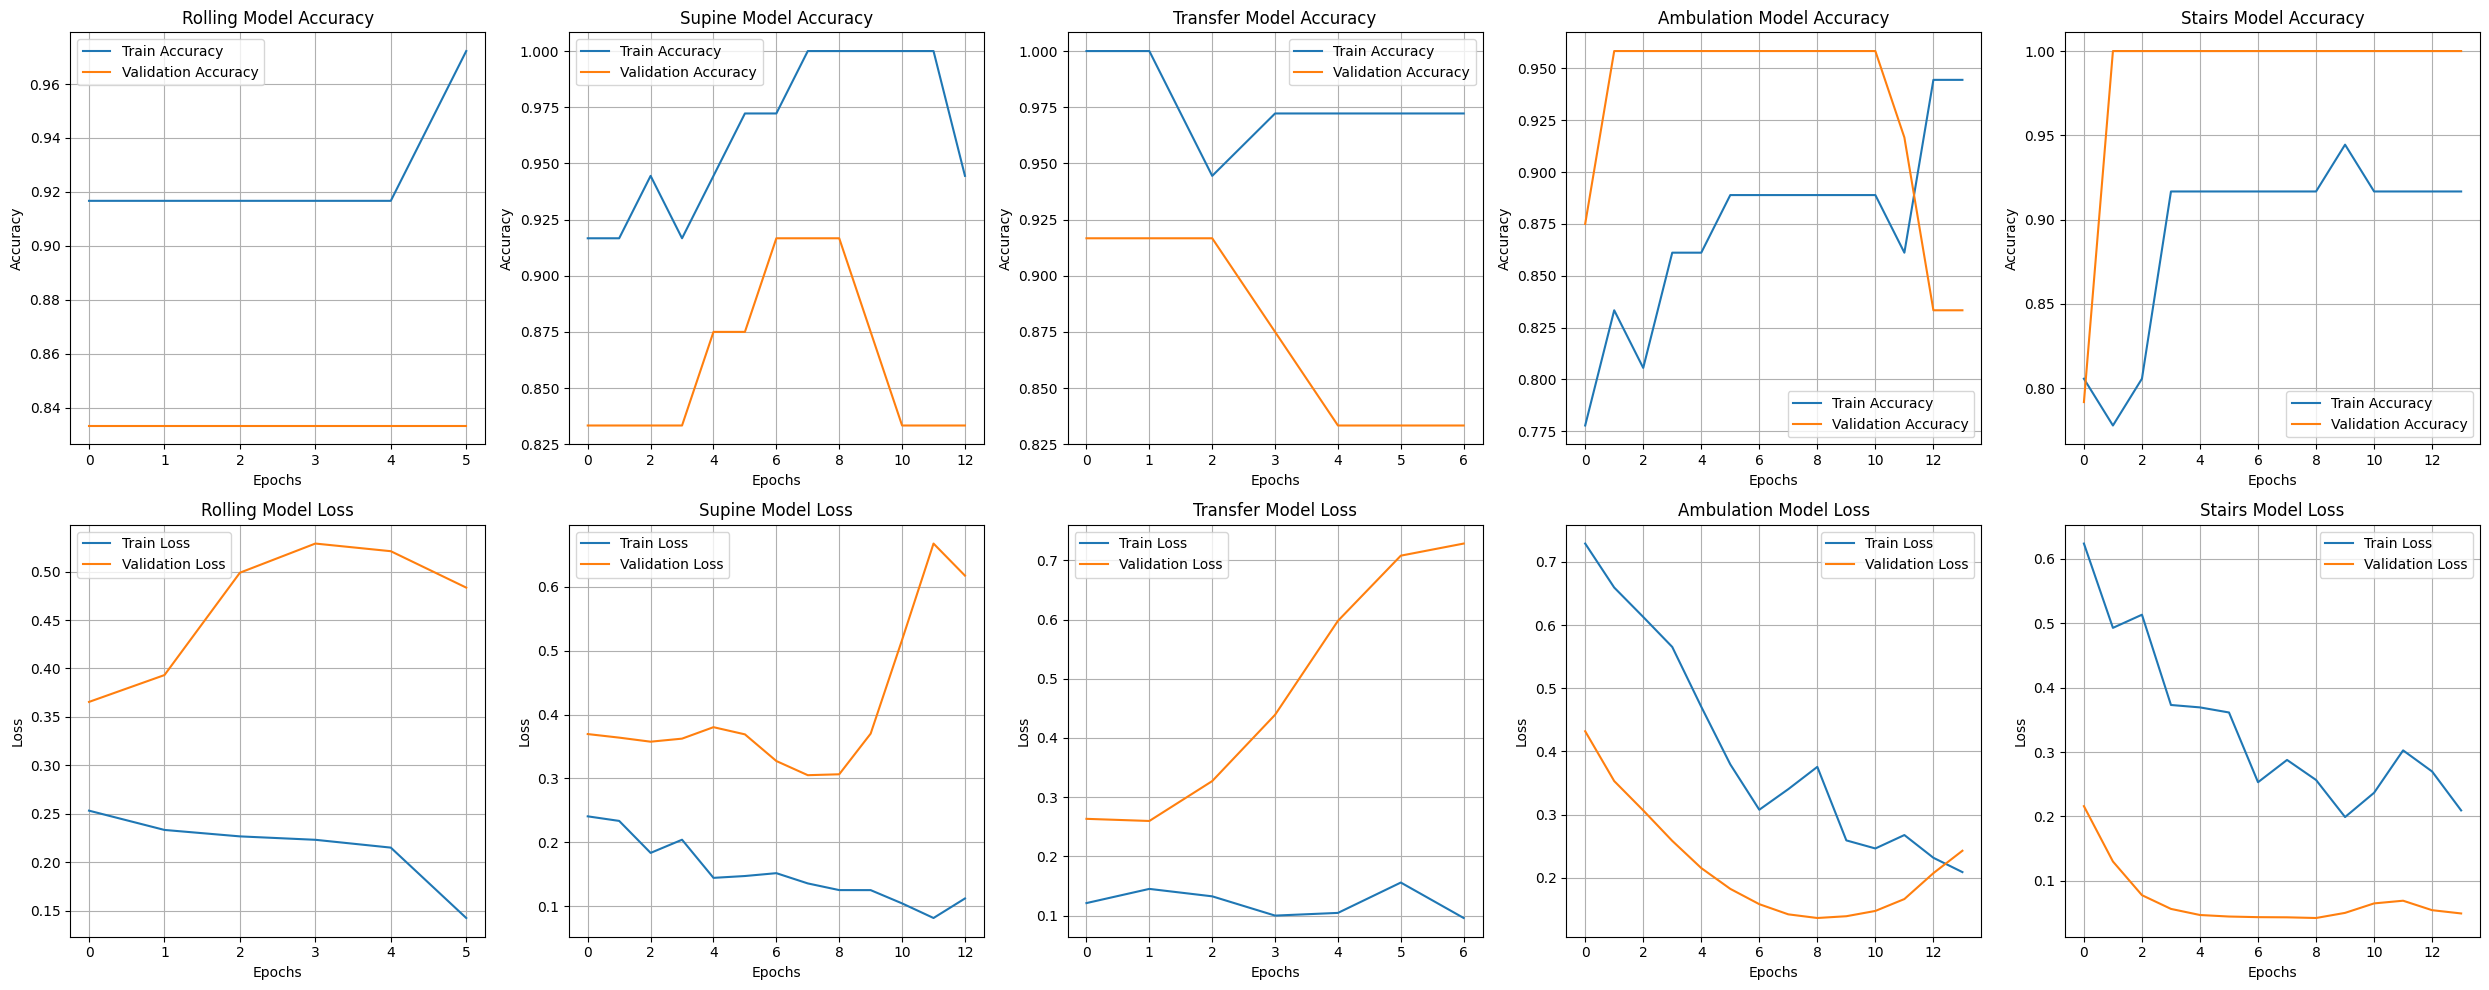

In [13]:
import matplotlib.pyplot as plt

# List of model histories and their titles
histories = [
    (rolling_history, 'Rolling'),
    (supine_history, 'Supine'),
    (transfer_history, 'Transfer'),
    (ambulation_history, 'Ambulation'),
    (stairs_history, 'Stairs')
]

# Create a 2x5 subplot
fig, axes = plt.subplots(2, 5, figsize=(25, 10))

# Iterate over the histories and plot
for idx, (history, title) in enumerate(histories):
    # Accuracy subplot (top row)
    axes[0, idx].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, idx].plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    axes[0, idx].set_title(f'{title} Model Accuracy')
    axes[0, idx].set_xlabel('Epochs')
    axes[0, idx].set_ylabel('Accuracy')
    axes[0, idx].legend()
    axes[0, idx].grid(True)

    # Loss subplot (bottom row)
    axes[1, idx].plot(history.history['loss'], label='Train Loss')
    axes[1, idx].plot(history.history.get('val_loss', []), label='Validation Loss')
    axes[1, idx].set_title(f'{title} Model Loss')
    axes[1, idx].set_xlabel('Epochs')
    axes[1, idx].set_ylabel('Loss')
    axes[1, idx].legend()
    axes[1, idx].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [23]:
#Generate a table of the the csv stored in the mass general folder named therapy table.csv
therapy_table = pd.read_csv("/Users/amanagrawal/Desktop/Mass General Data/therapy table.csv")

print(therapy_table.head())
# #define figure and axes
# fig, ax = plt.subplots()

# #hide the axes
# fig.patch.set_visible(False)
# ax.axis('off')
# ax.axis('tight')

# #create data
# df = therapy_table

# #create table
# table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# #display table
# fig.tight_layout()

# # Adjust font sizes and scaling
# table.auto_set_font_size(False)
# table.set_fontsize(8)
# table.scale(1.5, 1.5)  # Adjust scale for better readability


# plt.show()




                  Therapy Type  \
0             Physical Therapy   
1         Occupational Therapy   
2  Speech and Language Therapy   

                                      Metric(s) Name        Metric Values  \
0           AM-PAC 6 Click Functional Mobility Score              Rolling   
1  AM-PAC 6 Click Daily Activity Score, Modified ...  Lower body dressing   
2  Glassgow Coma Scale, IDDSI Food Consistency Fr...     GCS Verbal Score   

            Unnamed: 3          Unnamed: 4        Unnamed: 5  Unnamed: 6  \
0            Sit-Stand          Supine-Sit         Transfers  Ambulation   
1  Upper body dressing             Bathing         Toileting    Grooming   
2           Swallowing  Liquid consistency  Food consistensy         NaN   

  Unnamed: 7    Unnamed: 8  
0        NaN           NaN  
1    Feeding  Rankin Score  
2        NaN           NaN  


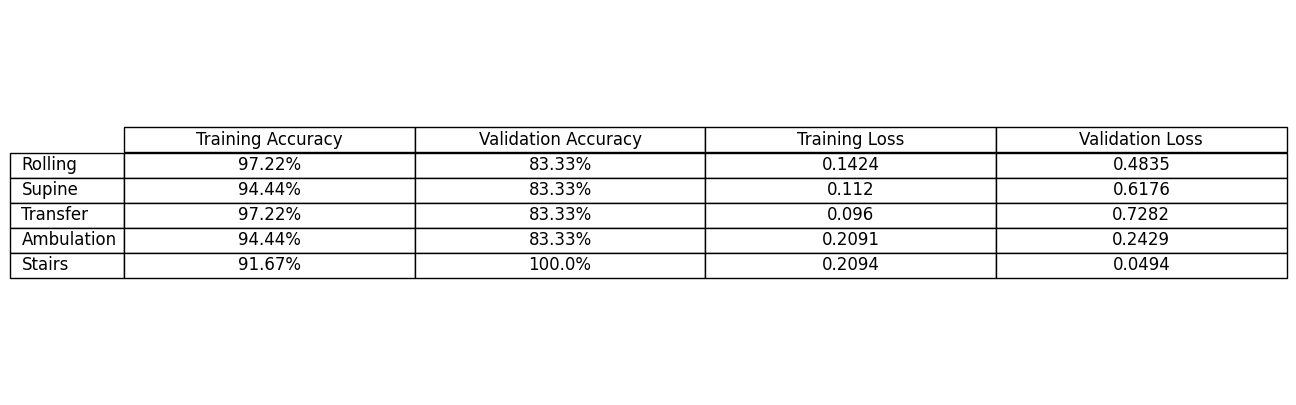

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the history variables are defined and have a .history attribute
histories = {
    "Rolling": rolling_history.history,
    "Supine": supine_history.history,
    "Transfer": transfer_history.history,
    "Ambulation": ambulation_history.history,
    "Stairs": stairs_history.history,
}

# Extract final metrics from the histories
data = {
    "Model": [],
    "Training Accuracy": [],
    "Validation Accuracy": [],
    "Training Loss": [],
    "Validation Loss": [],
}

for model_name, history in histories.items():
    data["Model"].append(model_name)
    data["Training Accuracy"].append(history["accuracy"][-1])
    data["Validation Accuracy"].append(history.get("val_accuracy", [None])[-1])
    data["Training Loss"].append(history["loss"][-1])
    data["Validation Loss"].append(history.get("val_loss", [None])[-1])


# Convert to a pandas DataFrame
metrics_df = pd.DataFrame(data)
metrics_df.set_index("Model", inplace=True)

# round to 4 decimal places
metrics_df = metrics_df.round(4)

# Convert the accuracies to percentages, with percent sign
metrics_df["Training Accuracy"] = (metrics_df["Training Accuracy"] * 100).astype(str) + "%"
metrics_df["Validation Accuracy"] = (metrics_df["Validation Accuracy"] * 100).astype(str) + "%"


# Create a matplotlib table to display the metrics
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis("off")  # Turn off the axis

# Add the table
table = ax.table(
    cellText=metrics_df.values,
    colLabels=metrics_df.columns,
    rowLabels=metrics_df.index,
    cellLoc="center",
    loc="center",
)

# Adjust font sizes and scaling
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)  # Adjust scale for better readability

# Show the table
plt.show()